# Testing RNN in over10

In [115]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
import time

In [286]:
model = Sequential() # istanza di Sequential 
model.add(Dense(128, input_dim=100, activation='relu',name="hidden1")) #strato di input + hidden
model.add(Dropout(0.5))
#model.add(Dense(1, activation='sigmoid',name="sigmoid"))
model.add(Dense(1, activation='softmax',name="output")) #strato di output
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 128)               12928     
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 129       
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________


In [287]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=0.1, momentum=0.975, nesterov=False)

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

In [144]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [0]:
#dati input di apprendimento composto da mille vettori di 20 float random
x_train = np.random.random((1000, 20))  #dati di out di apprendimento (train) composto da mille scalari random da 0 a 1 
y_train = np.random.randint(2, size=(1000, 1))   #dati input di validazione composto da 100 vettori di 20 float random 
x_test = np.random.random((100, 20))    #dati di out di validazione (test) composto da mille scalari random da 0 a 1 
y_test = np.random.randint(2, size=(100, 1))

In [241]:
from sklearn.model_selection import train_test_split

bankdata = pd.read_csv("../data/reviews_Video_Games_5-over10-data_frame.csv")

# x = bankdata.drop('utility', axis=1).drop('text', axis=1)
# y = bankdata['utility']

dataset = bankdata.values
X = dataset[:,2:].astype(float)
Y = dataset[:,1]

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [269]:
bankdata = pd.read_csv("../data/reviews_Video_Games_5-over10-data_frame.csv")

bankdata = bankdata.drop('text',axis=1)
np_bankdata = np.asarray(bankdata,dtype=np.float32)

for i in range(2,101):
    minx = np.min( np_bankdata[:,i] )
    maxx = np.max( np_bankdata[:,i])
    np_bankdata[:,i] = (np_bankdata[:,i]-minx)/(maxx-minx)

train, test = train_test_split(np_bankdata)

x_train = train[0:,1:]
y_train = train[0:,:1]

x_test = test[0:,1:]
y_test = test[0:,:1]

In [288]:
start_time=time.time()

history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=200, batch_size=512, verbose=0)#, validation_split=0.2)

elapsed_time = time.time() - start_time
t = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print('Elapsed time (learning):', t)

Elapsed time (learning): 00:00:52


In [289]:
score = model.evaluate(x_test, y_test, batch_size=64, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4602416037690287
Test accuracy: 0.5397583964090019


In [290]:
y_pred = model.predict(x_test)

# from sklearn.metrics import classification_report, confusion_matrix
# print(confusion_matrix(y_test,y_pred))
# print(classification_report(y_test,y_pred))

correct=0
for i in range(0,len(y_pred)):
    if y_pred[i]==y_test[i]:
        correct+=1
    
print("Corrected points:",correct,"over",len(y_pred))
print("Uncorrected points:",len(y_pred)-correct,"over",len(y_pred))
print("Accuracy",correct/len(y_pred))

Corrected points: 4066 over 7533
Uncorrected points: 3467 over 7533
Accuracy 0.5397583963892207


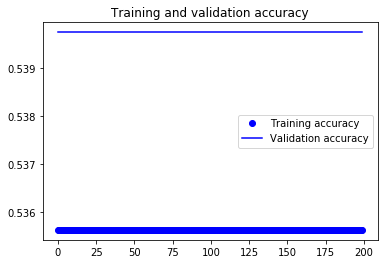

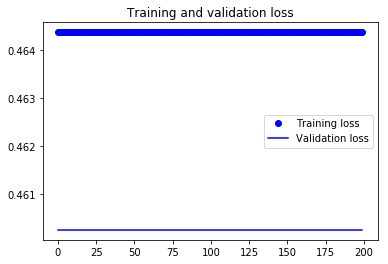

In [291]:
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [292]:
f=0
for i in y_pred:
    if i==0:
        f+=1
print(len(pred))
print(f)

7533
0


In [0]:
model.save('../data/lstm_model.h5')

In [6]:
from keras.models import load_model

model = load_model('../data/lstm_model.h5')
# make predictions
yhat = model.predict(x_test, verbose=0)
print(yhat)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [7]:
len(yhat)

6027

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import re
import pandas as pd

def get_stop_words(stop_file_path):
  """load stop words """    
  with open(stop_file_path, 'r', encoding="utf-8") as f:
    stopwords = f.readlines()
    stop_set = set(m.strip() for m in stopwords)
  return frozenset(stop_set)

def compute_tfidf(doc,cv,tfidf_transformer,attributes):
  #generate tf-idf for the given document
  tf_idf_vector=tfidf_transformer.transform(cv.transform([doc])) 
  #sort the tf-idf vectors by descending order of scores
  sorted_items=sort_coo(tf_idf_vector.tocoo())
  #extract all items from document
  keywords=extract_topn_from_vector(feature_names,sorted_items,len(doc))
  dict_doc={}
  for e in attributes:
    if e in keywords:
      dict_doc[e]=keywords[e]
    else:
      dict_doc[e]=0
  return dict_doc

def sort_coo(coo_matrix):
  tuples = zip(coo_matrix.col, coo_matrix.data)
  return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
  """get the feature names and tf-idf score of top n items"""
  #use only topn items from vector
  sorted_items = sorted_items[:topn] 
  score_vals = []
  feature_vals = []
  # word index and corresponding tf-idf score
  for idx, score in sorted_items:
    #keep track of feature name and its corresponding score
    score_vals.append(round(score, 3))
    feature_vals.append(feature_names[idx])
  #create a tuples of feature,score
  #results = zip(feature_vals,score_vals)
  results= {}
  for idx in range(len(feature_vals)):
    results[feature_vals[idx]]=score_vals[idx]    
  return results

df=pd.read_csv('../data/reviews_Video_Games_5-over10.csv')

#load a set of stop words
stopwords=get_stop_words('../data/stopwords.txt')

#get the text column 
docs=df['text'].tolist()

#create a vocabulary of words, 
#ignore words that appear in 99,999999% of documents, 
#eliminate stop words
cv=CountVectorizer(stop_words=stopwords)
word_count_vector=cv.fit_transform(docs)

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'vis', 'viser', 'visest'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [13]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
porter_stemmer = PorterStemmer()
en_stops = set(stopwords.words('english'))

#binary search to improve efficency
def binary_search(e,l,inizio,fine):
  if inizio>fine or e<l[inizio] or e>l[fine-1]:
    return False
  else:
    mezzo=int((inizio+fine)/2)
    m=l[mezzo]
    if e==m:
      return True
    elif e>m:
      return binary_search(e,l,mezzo,fine)
    else:
      return binary_search(e,l,inizio,mezzo)

#removing symbols and adding space after them
def prepreprocess(frase):
  s=''
  syms=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','è','é','à','ò','ì','ù']
  for char in frase:
    if char not in syms:
      s+=' '
    else:
      s+=char
  return s

#preprocess using prepreprocess fase and stemming and removing stopwords
def preprocess(frase,en_words):
  l=[]
  for word in prepreprocess(frase.lower()).split(' '):
    w=word.lower()
    if w not in en_stops and len(w)>2 and binary_search(w,en_words,0,len(en_words)):
        l.append(porter_stemmer.stem(w))
  return repr(' '.join(l))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer

DF=pd.read_csv('../data/reviews_Video_Games_5-over10-data_frame.csv')

# summary='Great game of all the time!!!'
# reviewText="I've never played this game first, but since the initial install I've fallen in love <3 !!! It's amazing because shooting mode is very easy and level of entertainment is fantastic! I'll play for hour and hour so long!!! Very recommended!!!!"

summary='hahah'
reviewText="I like obama because he loves me so much and other people wanna play this game"

en_words=sorted(open('../data/en_words.txt', 'r').read().lower().split('\n'))
doc=preprocess(str(summary+' '+reviewText),en_words)

feature_names=cv.get_feature_names()

dict_doc=compute_tfidf(doc,cv,tfidf_transformer,list(DF.columns[2:]))

data_doc=[]
for v in dict_doc.values():
  data_doc.append(float(v))

In [106]:
dc=[]
dc.append(data_doc)
dc.append(data_doc)

In [107]:
s = "hi everyone, I'm so happy!"
model.predict(np.array(dc[0:1]), verbose=0)

array([[1.]], dtype=float32)

In [277]:
pred=model.predict(x_test,verbose=0)
f=0
for i in pred:
    if i==0:
        f+=1
print(len(pred))
print(f)

7533
0


# Test

In [0]:
import numpy as np 
import pandas as pd
from keras.models import Sequential 
from keras.layers import Dense,Dropout
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [185]:
model = Sequential() # istanza di Sequential 
model.add(Dense(10, input_dim=13, activation='relu',name='hidde1')) #strato di input + hidden 
model.add(Dropout(0.5) )
model.add(Dense(1, activation='tanh',name='outLayer')) #strato di output
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidde1 (Dense)               (None, 10)                140       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
outLayer (Dense)             (None, 1)                 11        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [0]:
wine_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)


np_wine_data = np.asarray(wine_data,dtype=np.float32)

for i in range(1,14):
  minx = np.min( np_wine_data[:,i] )
  maxx = np.max( np_wine_data[:,i])
  np_wine_data[:,i] = (np_wine_data[:,i]-minx)/(maxx-minx )
  



train, train_val = train_test_split(np_wine_data)



x_train = train[0:,1:]
y_train = train[0:,:1]-2

x_test = train_val[0:,1:]
y_test = train_val[0:,:1]-2 

#print(  np_wine_data[:,1]   )

In [188]:
model.fit(x_train, y_train, validation_data=(x_test,y_test),epochs=500, batch_size=64,verbose=0)

In [189]:
model.fit(x_train, y_train, validation_data=(x_test,y_test),epochs=20, batch_size=64,verbose=1)

Train on 133 samples, validate on 45 samples
Epoch 1/20
133/133 [==============================] - 0s 152us/step - loss: 0.1462 - acc: 0.9098 - val_loss: 0.0510 - val_acc: 0.9556
Epoch 2/20
133/133 [==============================] - 0s 154us/step - loss: 0.1016 - acc: 0.8947 - val_loss: 0.0514 - val_acc: 0.9556
Epoch 3/20
133/133 [==============================] - 0s 143us/step - loss: 0.1432 - acc: 0.8872 - val_loss: 0.0508 - val_acc: 0.9556
Epoch 4/20
133/133 [==============================] - 0s 127us/step - loss: 0.1322 - acc: 0.9098 - val_loss: 0.0510 - val_acc: 0.9556
Epoch 5/20
133/133 [==============================] - 0s 149us/step - loss: 0.1321 - acc: 0.8872 - val_loss: 0.0515 - val_acc: 0.9556
Epoch 6/20
133/133 [==============================] - 0s 141us/step - loss: 0.1123 - acc: 0.9173 - val_loss: 0.0511 - val_acc: 0.9556
Epoch 7/20
133/133 [==============================] - 0s 133us/step - loss: 0.1101 - acc: 0.9023 - val_loss: 0.0525 - val_acc: 0.9556
Epoch 8/20
133/13